In [6]:
# ======================
# 📁 Step 2: Upload Dataset
# ======================
import os 
import pandas as pd

dataset = './documents/ratings_Electronics (1).csv'
if os.path.exists(dataset):
    print(f"Dataset found at {dataset}")
else:
    print(f"Dataset not found at {dataset}. Please upload the dataset.")


# Replace the name below with your actual file name
df = pd.read_csv(dataset, names=['userId', 'productId', 'rating', 'timestamp'], header=0)

# Display the first few rows of the DataFrame to verify the data
print("Dataset loaded successfully!")
df.head()


Dataset found at ./documents/ratings_Electronics (1).csv
Dataset loaded successfully!


,userId,productId,rating,timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [ ]:
# ======================
# 🔍 Step 3: Preprocess Dataset
# ======================
# Keep only 5-star reviews
df = df[df['rating'] == 5.0]

# Keep only relevant columns
df = df[['userId', 'productId']]
df.dropna(inplace=True)

# Optional: reduce size for speed
# df = df.sample(10000)

# Show all rows and columns in the DataFrame
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Show full table
df

dtype(df["rating"]): float64



In [ ]:
# ======================
# 🧱 Step 4: Build Bipartite Graph
# ======================
import networkx as nx

B = nx.Graph()

# Add user and product nodes
B.add_nodes_from(df['userId'].unique(), bipartite=0)
B.add_nodes_from(df['productId'].unique(), bipartite=1)

# Add edges from user-product interactions
edges = list(df.itertuples(index=False, name=None))
B.add_edges_from(edges)

print(f"Bipartite Graph — Nodes: {len(B.nodes())}, Edges: {len(B.edges())}")


Bipartite Graph — Nodes: 2955803, Edges: 4347541


In [ ]:
# ======================
# 🔁 Step 5: Project to Product Graph
# ======================
from networkx.algorithms import bipartite

# Get product nodes (bipartite=1)
product_nodes = {n for n, d in B.nodes(data=True) if d.get('bipartite') == 1}

# Project onto product nodes
P = bipartite.weighted_projected_graph(B, product_nodes)

print(f"Projected Product Graph — Nodes: {len(P.nodes())}, Edges: {len(P.edges())}")


Projected Product Graph — Nodes: 358458, Edges: 7185546


In [ ]:
# prompt: Print the first 100 product_list

product_list = list(P.nodes())
print(product_list[:2])


['B00E0U8JZE', 'B00496FELQ']


In [ ]:
# ======================
# 💡 Step 6: Recommendation Function
# ======================

def recommend_products(product_id, n=4, max_products=10):
    if product_id not in P:
        return "Product not found in network."

    # Get neighbors and their weights (connections between products)
    neighbors = [(neighbor, data["weight"]) for neighbor, data in P[product_id].items()]

    # Sort by weight (highest first)
    neighbors.sort(key=lambda x: x[1], reverse=True)

    # Get the top N unique weights
    unique_weights = sorted(set(weight for _, weight in neighbors), reverse=True)
    top_n_weights = unique_weights[:n]  # Select the highest N weights

    # Filter to include all products with these top weights
    filtered_neighbors = [(prod, weight) for prod, weight in neighbors if weight in top_n_weights]

    # Limit the number of displayed products to `max_products`
    filtered_neighbors = filtered_neighbors[:max_products]

    return filtered_neighbors


In [ ]:
# ======================
# 🔘 Step 7: Plot Star Network with Top N Neighbors and Edge Weights
# ======================

import networkx as nx
import matplotlib.pyplot as plt

def plot_recommendations(product_id, recommendations, max_products=10):
    # Create a new graph for visualization
    G = nx.Graph()

    # Add the central node (selected product)
    G.add_node(product_id)

    # Sort recommendations based on weight
    recommendations.sort(key=lambda x: x[1], reverse=True)

    # Add nodes and edges for the top max_products neighbors
    for i, (neighbor, weight) in enumerate(recommendations[:max_products]):
        G.add_node(neighbor)
        G.add_edge(product_id, neighbor, weight=weight)

    # Get the top 4 recommendations (based on the highest weights)
    top_4_neighbors = recommendations[:4]

    # Define edge colors and thickness based on weight
    edge_colors = ['red' if (prod, weight) in top_4_neighbors else 'gray' for prod, weight in recommendations[:max_products]]
    edge_widths = [weight / max([w for _, w in recommendations]) * 5 for _, weight in recommendations[:max_products]]  # Scale width based on max weight

    # Draw the network with the central node in the middle
    pos = nx.circular_layout(G)  # Arrange nodes in a circle
    pos[product_id] = (0, 0)  # Place the central node (product) in the center

    # Draw nodes and labels
    plt.figure(figsize=(10, 8))
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='lightblue')
    nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')

    # Draw edges with color and width based on weight
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths, alpha=0.6)

    # Add edge labels to display weights
    edge_labels = {(product_id, neighbor): str(weight) for (neighbor, weight) in recommendations[:max_products]}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, font_color='black')

    # Display the plot
    plt.title(f"Star Network: Recommendations for {product_id}")
    plt.axis("off")  # Hide axes
    plt.show()



Combobox(value='', description='Product', layout=Layout(width='60%'), options=('B00E0U8JZE', 'B00496FELQ', 'B0…

Dropdown(description='Top N', index=3, options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10), value=4)

Button(description='Show Recommendations', style=ButtonStyle())

Top Recommended Products (with weights):
Product ID: B005DOK8NW, Weight: 30
Product ID: B007R5YDYA, Weight: 7
Product ID: B007WTAJTO, Weight: 4
Product ID: B004JWA70I, Weight: 4
Product ID: B0074BW614, Weight: 4
Product ID: B003ELYQGG, Weight: 4
Product ID: B005DOKHLK, Weight: 3
Product ID: B004GF8TIK, Weight: 3
Product ID: B008GGH4FY, Weight: 3
Product ID: B004SD2562, Weight: 3


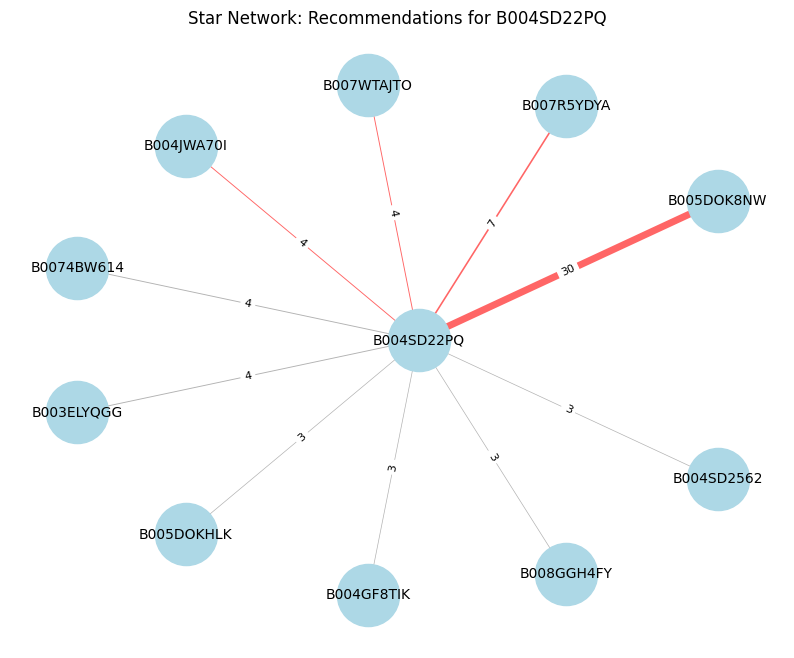

Top Recommended Products (with weights):
Product ID: B004Z4FBE2, Weight: 1
Product ID: B003ES5ZUU, Weight: 1
Product ID: B005K1Y4I8, Weight: 1
Product ID: B00591GIMY, Weight: 1
Product ID: B007528LF2, Weight: 1
Product ID: B001RB24S2, Weight: 1
Product ID: B005B9CNMI, Weight: 1
Product ID: B004V4IWHY, Weight: 1
Product ID: B0047OY2HC, Weight: 1
Product ID: B000I963XQ, Weight: 1


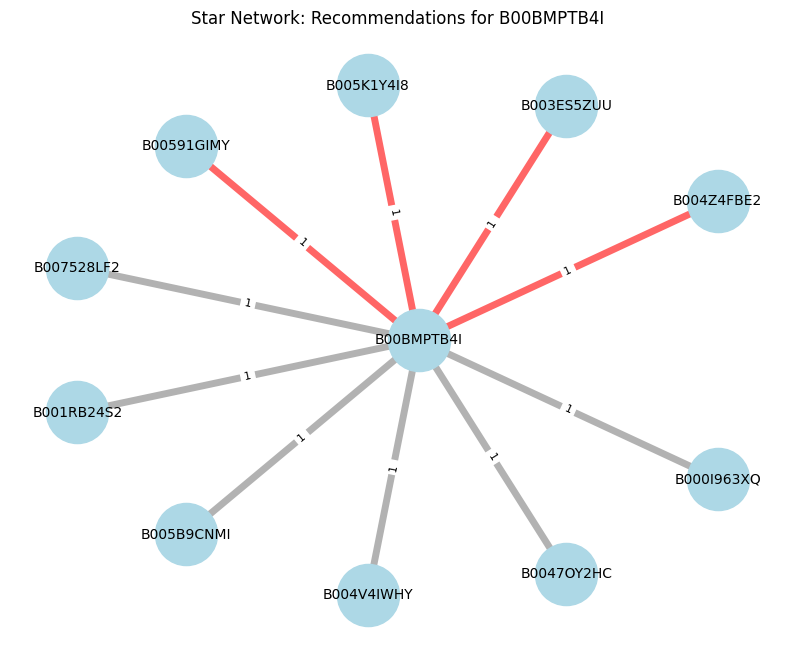

In [ ]:
# ======================
# 🔘 Step 8: Add Interactive Dropdowns
# ======================

import ipywidgets as widgets
from IPython.display import display

# Function to handle user interaction
def on_click(b):
    product_id = product_dropdown.value
    n_neighbors = n_dropdown.value
    recommendations = recommend_products(product_id, n_neighbors, max_products=10)

    # Print the list of neighbors with their weights
    print("Top Recommended Products (with weights):")
    for neighbor, weight in recommendations:
        print(f"Product ID: {neighbor}, Weight: {weight}")

    # Plot the star network for the selected product and its top neighbors
    plot_recommendations(product_id, recommendations)

# Create the widgets for product selection and top N selection
product_list = list(P.nodes)[:5000]  # Limit options for speed

# Searchable dropdown for product selection
product_dropdown = widgets.Combobox(
    options=product_list,
    placeholder="Type to search...",
    description="Product",
    layout=widgets.Layout(width='60%')
)

# Dropdown for selecting "Top N"
n_dropdown = widgets.Dropdown(
    options=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    value=4,
    description="Top N"
)

# Button to trigger recommendation
button = widgets.Button(description="Show Recommendations")
button.on_click(on_click)

# Display the widgets
display(product_dropdown, n_dropdown, button)
